In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
import tensorflow as tf
from tensorflow.keras.layers import Dropout

2025-09-25 22:46:35.208339: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-25 22:46:35.208563: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-25 22:46:35.259215: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-25 22:46:36.117244: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU enabled")
    except RuntimeError as e:
        print(e)

E0000 00:00:1758820596.326039   53596 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1758820596.333108   53596 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
!pip install --upgrade yfinance

In [4]:
ticker = "AAPL"
data = yf.download(ticker, start="2018-01-01", end="2023-01-01")

/tmp/ipykernel_53596/3633138759.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2018-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [5]:
def get_SMA(data, period):
    return data['Close'].rolling(period).mean()

In [6]:
data['SMA_5'] = get_SMA(data, 5)
data['SMA_10'] = get_SMA(data, 10)
data['RSI'] = ta.momentum.RSIIndicator(data['Close'].squeeze(), window=14).rsi()
data['Typical'] = (data['High'] + data['Low'] + data['Close']) / 3
data['Target'] = data['Close'].shift(-1)

In [7]:
data.dropna(inplace=True)

In [8]:
def get_EMA(data, period):
    EMA_col = []
    EMA_col.append(data[f"SMA_{period}"].iloc[0])
    multiplier = 2 / (period + 1)
    for i in range(1, len(data)):
        EMA = (data[f"SMA_{period}"].iloc[i] - EMA_col[i-1]) * multiplier + EMA_col[i-1]
        EMA_col.append(EMA)
    return EMA_col

In [9]:
for period in [5,10]:
    data[f"EMA_{period}"] = get_EMA(data, period)

In [10]:
def get_TR(data):
    TR_col = [float(data["High"].iloc[0] - data["Low"].iloc[0])]
    for i in range(1, len(data)):
        TR = max(float(data["High"].iloc[i] - data["Low"].iloc[i]),
                 float(abs(data["High"].iloc[i] - data["Close"].iloc[i-1])),
                 float(abs(data["Low"].iloc[i] - data["Close"].iloc[i-1])))
        TR_col.append(TR)
    return TR_col

In [11]:
data["TR"] = get_TR(data)

/tmp/ipykernel_53596/265326435.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  TR_col = [float(data["High"].iloc[0] - data["Low"].iloc[0])]
/tmp/ipykernel_53596/265326435.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  TR = max(float(data["High"].iloc[i] - data["Low"].iloc[i]),
/tmp/ipykernel_53596/265326435.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(abs(data["High"].iloc[i] - data["Close"].iloc[i-1])),
/tmp/ipykernel_53596/265326435.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(abs(data["Low"].iloc[i] - data["Close"].iloc[i-1])))


In [12]:
features_LSTM = ["Close", "High", "Low", "Open", "Volume", "SMA_5", "SMA_10",
                 "RSI", "Typical", "EMA_5", "EMA_10", "TR"]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(data[features_LSTM])
y_scaled = scaler_y.fit_transform(data[['Target']])

train_size = int(len(data) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

look_back = 20

def create_LSTM_dataset(X, y, look_back=1):
    Xs, ys = [], []
    for i in range(len(X)-look_back):
        Xs.append(X[i:(i+look_back), :])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

X_train_LSTM, y_train_LSTM = create_LSTM_dataset(X_train, y_train, look_back)
X_test_LSTM, y_test_LSTM = create_LSTM_dataset(X_test, y_test, look_back)

In [13]:
tf.random.set_seed(36)
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, X_train_LSTM.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/home/varnan/miniconda3/envs/stock_forecast/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.fit(X_train_LSTM, y_train_LSTM, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011   
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2721e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5798e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7161e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2015e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9136e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7623e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6627e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5641e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4494e-04
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3238e-04
Epoch 13/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1993e-04
Epoch 14/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0864e-04
Epoch 15/50
61/61 ━━━━━━━━━━━━━━━━

In [15]:
train_pred = model.predict(X_train_LSTM)
test_pred = model.predict(X_test_LSTM)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [16]:
train_pred_inv = scaler_y.inverse_transform(train_pred)
y_train_inv = scaler_y.inverse_transform(y_train_LSTM)
test_pred_inv = scaler_y.inverse_transform(test_pred)
y_test_inv = scaler_y.inverse_transform(y_test_LSTM)

In [17]:
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

Train RMSE: 2.38
Test RMSE: 4.75


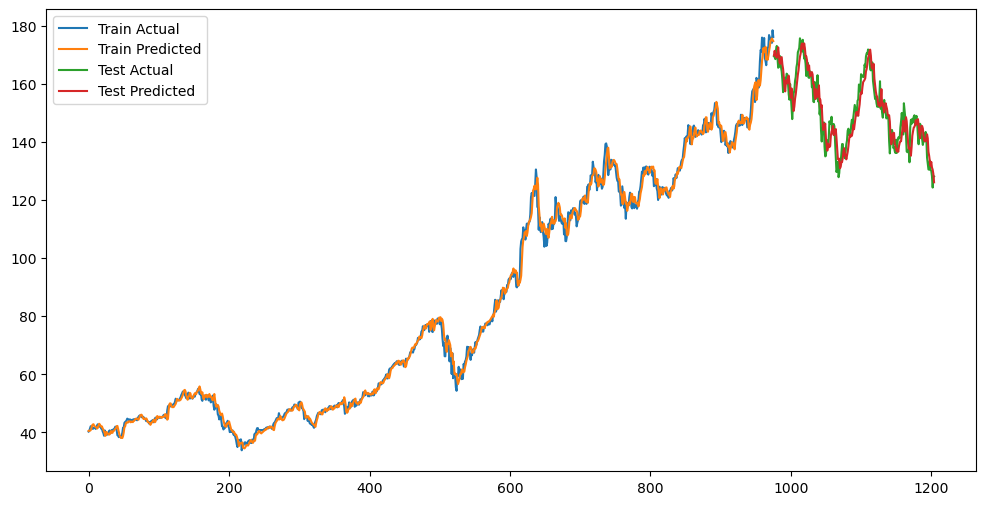

In [18]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(len(y_train_inv)), y_train_inv, label='Train Actual')
plt.plot(np.arange(len(train_pred_inv)), train_pred_inv, label='Train Predicted')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_test_inv)), y_test_inv, label='Test Actual')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(test_pred_inv)), test_pred_inv, label='Test Predicted')
plt.legend()
plt.show()

### Advanced Feature Engineering

In [19]:
# Momentum Indicators

# Adding MACD values
data["SMA_12"] = get_SMA(data, period = 12)
data["SMA_26"] = get_SMA(data, period = 26)
data.dropna(inplace = True)
MACD_values = data["SMA_12"] - data["SMA_26"]
data["MACD"] = MACD_values

In [20]:
# Price Derivatives

# Daily returns
data["Daily_Return"] = data['Close'].pct_change()

# Log returns
data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))

In [21]:
# Volume Based

# On-Balance Volume (OBV)
data['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=data['Close'].squeeze(), volume=data['Volume'].squeeze()).on_balance_volume()

In [22]:
data.dropna(inplace = True)

In [23]:
# Volatility

# Average True Range
atr_indicator = ta.volatility.AverageTrueRange(
    high=data['High'].squeeze(),
    low=data['Low'].squeeze(),
    close=data['Close'].squeeze(),
    window=14
)
data['ATR'] = atr_indicator.average_true_range()

In [24]:
bb_indicator = ta.volatility.BollingerBands(
    close=data['Close'].squeeze(),
    window=14,
    window_dev=2
)

data['BB_mavg'] = bb_indicator.bollinger_mavg()
data['BB_hband']= bb_indicator.bollinger_hband()
data['BB_lband']= bb_indicator.bollinger_lband()
data['BB_pband'] = bb_indicator.bollinger_pband()

In [25]:
data.dropna(inplace = True)

In [26]:
data.head()

Price,Close,High,Low,Open,Volume,SMA_5,SMA_10,RSI,Typical,Target,...,SMA_26,MACD,Daily_Return,Log_Return,OBV,ATR,BB_mavg,BB_hband,BB_lband,BB_pband
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-19,41.261185,41.771947,40.875170,41.736643,133787200,41.914572,41.913630,50.509964,41.302767,41.247040,...,41.022176,0.830374,-0.015279,-0.015397,-237183200,0.737057,41.810434,42.726285,40.894584,0.200142
2018-03-20,41.247040,41.614224,41.176427,41.247040,78597600,41.691907,41.879971,50.377521,41.345897,40.312618,...,41.192641,0.640882,-0.000343,-0.000343,-315780800,0.715681,41.762014,42.719274,40.804753,0.231017
2018-03-21,40.312618,41.211748,40.310262,41.199978,148219600,41.354382,41.791470,42.457365,40.611543,39.743000,...,41.270134,0.454529,-0.022654,-0.022915,-464000400,0.731474,41.699304,42.885696,40.512911,-0.084413
2018-03-22,39.743000,40.644482,39.684156,40.013679,165963200,40.893047,41.601052,38.485290,40.023879,38.822689,...,41.310962,0.260315,-0.014130,-0.014231,-629963600,0.747821,41.575564,43.132938,40.018189,-0.088350
2018-03-23,38.822689,39.994854,38.822689,39.634731,164115200,40.277306,41.247049,33.097668,39.213411,40.665684,...,41.288964,0.084402,-0.023157,-0.023429,-794078800,0.778131,41.375832,43.480716,39.270947,-0.106480


Retraining same LSTM model to find how much better did the data fit now

In [27]:
features_LSTM2 = [col for col in data.columns if col != 'Target']

scaler_X_2 = MinMaxScaler()
scaler_y_2 = MinMaxScaler()

X_scaled_2 = scaler_X_2.fit_transform(data[features_LSTM2])
y_scaled_2 = scaler_y_2.fit_transform(data[['Target']])

train_size = int(len(data) * 0.8)
X_train_2, X_test_2 = X_scaled_2[:train_size], X_scaled_2[train_size:]
y_train_2, y_test_2 = y_scaled_2[:train_size], y_scaled_2[train_size:]

look_back_2 = 20

def create_LSTM_dataset(X, y, look_back=1):
    Xs, ys = [], []
    for i in range(len(X)-look_back):
        Xs.append(X[i:(i+look_back), :])
        ys.append(y[i + look_back])
    return np.array(Xs), np.array(ys)

X_train_LSTM_2, y_train_LSTM_2 = create_LSTM_dataset(X_train_2, y_train_2, look_back_2)
X_test_LSTM_2, y_test_LSTM_2 = create_LSTM_dataset(X_test_2, y_test_2, look_back_2)

In [28]:
model2 = Sequential()
model2.add(LSTM(50, input_shape=(look_back, X_train_LSTM_2.shape[2])))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mean_squared_error')

/home/varnan/miniconda3/envs/stock_forecast/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [29]:
model2.fit(X_train_LSTM_2, y_train_LSTM_2, epochs=200, batch_size=16, verbose=1)

Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3063e-04
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7238e-04
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8619e-04
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7575e-04
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4874e-04
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2827e-04
Epoch 8/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1375e-04
Epoch 9/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0219e-04
Epoch 10/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9244e-04
Epoch 11/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8419e-04
Epoch 12/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7724e-04
Epoch 13/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7138e-04
Epoch 14/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6645e-04
Epoch 15/200
59/59

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train RMSE: 1.71
Test RMSE: 4.63


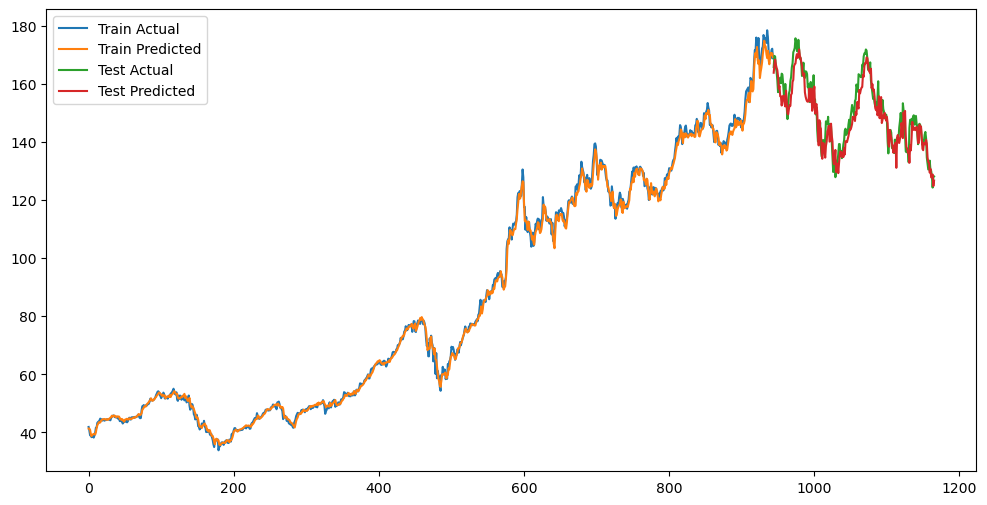

In [30]:
train_pred_2 = model2.predict(X_train_LSTM_2)
test_pred_2 = model2.predict(X_test_LSTM_2)

train_pred_inv_2 = scaler_y_2.inverse_transform(train_pred_2)
y_train_inv_2 = scaler_y_2.inverse_transform(y_train_LSTM_2)
test_pred_inv_2 = scaler_y_2.inverse_transform(test_pred_2)
y_test_inv_2 = scaler_y_2.inverse_transform(y_test_LSTM_2)

train_rmse_2 = np.sqrt(mean_squared_error(y_train_inv_2, train_pred_inv_2))
test_rmse_2 = np.sqrt(mean_squared_error(y_test_inv_2, test_pred_inv_2))

print(f"Train RMSE: {train_rmse_2:.2f}")
print(f"Test RMSE: {test_rmse_2:.2f}")

plt.figure(figsize=(12,6))
plt.plot(np.arange(len(y_train_inv_2)), y_train_inv_2, label='Train Actual')
plt.plot(np.arange(len(train_pred_inv_2)), train_pred_inv_2, label='Train Predicted')
plt.plot(np.arange(len(y_train_inv_2), len(y_train_inv_2)+len(y_test_inv_2)), y_test_inv_2, label='Test Actual')
plt.plot(np.arange(len(y_train_inv_2), len(y_train_inv_2)+len(test_pred_inv_2)), test_pred_inv_2, label='Test Predicted')
plt.legend()
plt.show()

Trying out stacked LSTM

In [33]:
data.columns

MultiIndex([(       'Close', 'AAPL'),
            (        'High', 'AAPL'),
            (         'Low', 'AAPL'),
            (        'Open', 'AAPL'),
            (      'Volume', 'AAPL'),
            (       'SMA_5',     ''),
            (      'SMA_10',     ''),
            (         'RSI',     ''),
            (     'Typical',     ''),
            (      'Target',     ''),
            (       'EMA_5',     ''),
            (      'EMA_10',     ''),
            (          'TR',     ''),
            (      'SMA_12',     ''),
            (      'SMA_26',     ''),
            (        'MACD',     ''),
            ('Daily_Return',     ''),
            (  'Log_Return',     ''),
            (         'OBV',     ''),
            (         'ATR',     ''),
            (     'BB_mavg',     ''),
            (    'BB_hband',     ''),
            (    'BB_lband',     ''),
            (    'BB_pband',     '')],
           names=['Price', 'Ticker'])

In [35]:
model_stack_LSTM = Sequential()
model_stack_LSTM.add(LSTM(50, return_sequences=True, input_shape=(look_back, X_train_LSTM_2.shape[2])))
model_stack_LSTM.add(LSTM(50, input_shape=(look_back, X_train_LSTM_2.shape[2])))
model_stack_LSTM.add(Dropout(0.2))
model_stack_LSTM.add(Dense(1))
model_stack_LSTM.compile(optimizer='adam', loss='mean_squared_error')

/home/varnan/miniconda3/envs/stock_forecast/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
model_stack_LSTM.fit(X_train_LSTM_2, y_train_LSTM_2, epochs=400, batch_size=16, verbose=1)

Epoch 1/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 2/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 3/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 
Epoch 4/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 5/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 6/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010
Epoch 7/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010
Epoch 8/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011    
Epoch 9/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 10/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011
Epoch 11/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011    
Epoch 12/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010
Epoch 13/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012
Epoch 14/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011
Epoch 15/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train RMSE: 1.68
Test RMSE: 3.69


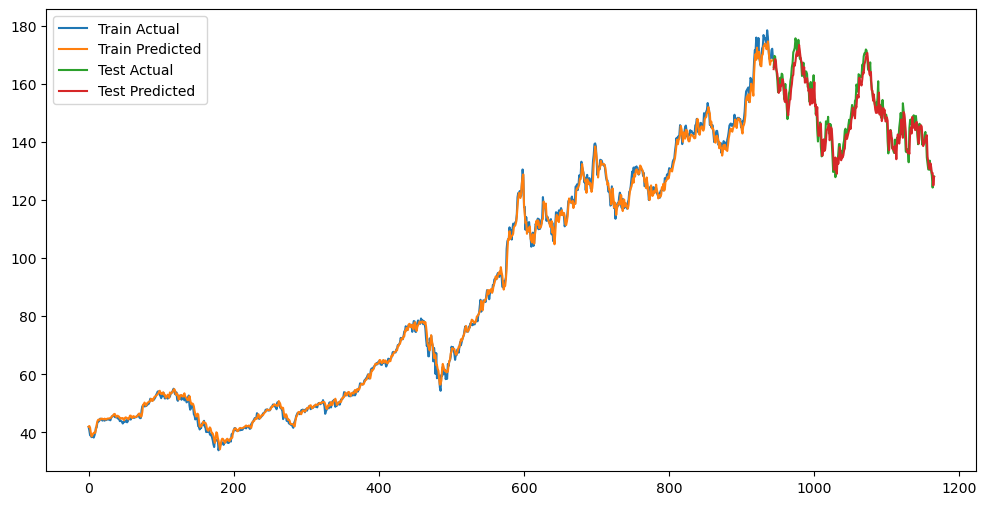

In [38]:
train_pred_3 = model_stack_LSTM.predict(X_train_LSTM_2)
test_pred_2 = model_stack_LSTM.predict(X_test_LSTM_2)

train_pred_inv_3 = scaler_y_2.inverse_transform(train_pred_3)
y_train_inv_3 = scaler_y_2.inverse_transform(y_train_LSTM_2)
test_pred_inv_3 = scaler_y_2.inverse_transform(test_pred_2)
y_test_inv_3 = scaler_y_2.inverse_transform(y_test_LSTM_2)

train_rmse_3 = np.sqrt(mean_squared_error(y_train_inv_3, train_pred_inv_3))
test_rmse_3 = np.sqrt(mean_squared_error(y_test_inv_3, test_pred_inv_3))

print(f"Train RMSE: {train_rmse_3:.2f}")
print(f"Test RMSE: {test_rmse_3:.2f}")

plt.figure(figsize=(12,6))
plt.plot(np.arange(len(y_train_inv_3)), y_train_inv_3, label='Train Actual')
plt.plot(np.arange(len(train_pred_inv_3)), train_pred_inv_3, label='Train Predicted')
plt.plot(np.arange(len(y_train_inv_3), len(y_train_inv_3)+len(y_test_inv_3)), y_test_inv_3, label='Test Actual')
plt.plot(np.arange(len(y_train_inv_3), len(y_train_inv_3)+len(test_pred_inv_3)), test_pred_inv_3, label='Test Predicted')
plt.legend()
plt.show()

More layers take more time to converge, but result in better accuracy

Trying GRU now

In [40]:
model_stack_GRU = Sequential()
model_stack_GRU.add(GRU(50, return_sequences=True, input_shape=(look_back, X_train_LSTM_2.shape[2])))
model_stack_GRU.add(GRU(50))
model_stack_GRU.add(Dropout(0.2))
model_stack_GRU.add(Dense(1))
model_stack_GRU.compile(optimizer='adam', loss='mean_squared_error')

/home/varnan/miniconda3/envs/stock_forecast/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
model_stack_GRU.fit(X_train_LSTM_2, y_train_LSTM_2, epochs=400, batch_size=16, verbose=1)

Epoch 1/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010
Epoch 2/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010
Epoch 3/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010    
Epoch 4/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011
Epoch 5/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9562e-04
Epoch 6/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6825e-04
Epoch 7/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2125e-04
Epoch 8/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1412e-04
Epoch 9/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.7067e-04
Epoch 10/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7363e-04
Epoch 11/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5850e-04
Epoch 12/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5023e-04
Epoch 13/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5898e-04
Epoch 14/400
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1189e-04
Epoch 15/400
59/59 ━━━━━━━━

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train RMSE: 1.86
Test RMSE: 4.40


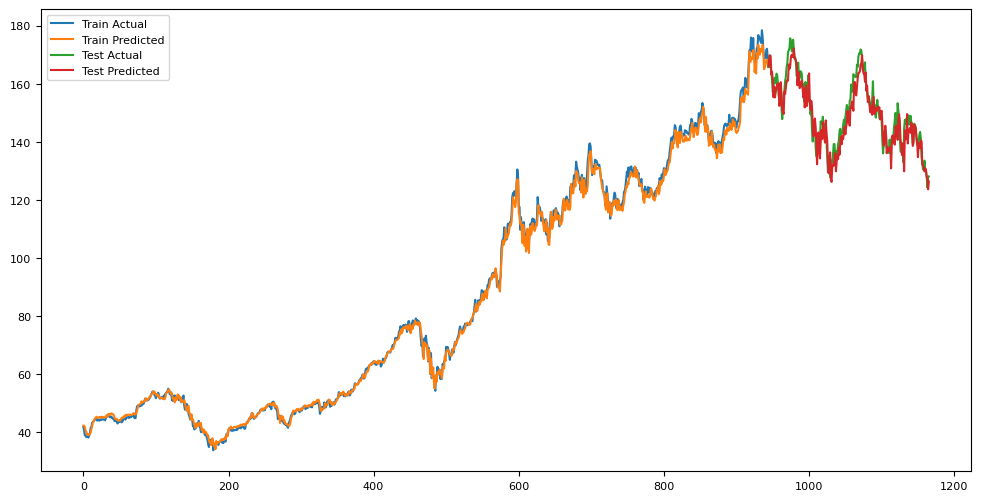

In [66]:
train_pred_4 = model_stack_GRU.predict(X_train_LSTM_2)
test_pred_4 = model_stack_GRU.predict(X_test_LSTM_2)

train_pred_inv_4 = scaler_y_2.inverse_transform(train_pred_4)
y_train_inv_4 = scaler_y_2.inverse_transform(y_train_LSTM_2)
test_pred_inv_4 = scaler_y_2.inverse_transform(test_pred_4)
y_test_inv_4 = scaler_y_2.inverse_transform(y_test_LSTM_2)

train_rmse_4 = np.sqrt(mean_squared_error(y_train_inv_4, train_pred_inv_4))
test_rmse_4 = np.sqrt(mean_squared_error(y_test_inv_4, test_pred_inv_4))

print(f"Train RMSE: {train_rmse_4:.2f}")
print(f"Test RMSE: {test_rmse_4:.2f}")

plt.figure(figsize=(12,6))
plt.plot(np.arange(len(y_train_inv_4)), y_train_inv_4, label='Train Actual')
plt.plot(np.arange(len(train_pred_inv_4)), train_pred_inv_4, label='Train Predicted')
plt.plot(np.arange(len(y_train_inv_4), len(y_train_inv_4)+len(y_test_inv_4)), y_test_inv_4, label='Test Actual')
plt.plot(np.arange(len(y_train_inv_4), len(y_train_inv_4)+len(test_pred_inv_4)), test_pred_inv_4, label='Test Predicted')
plt.legend()
plt.show()

As GRUs train faster and are computationally more efficient, their accuracy is not always exactly like LSTMs or better, but they are an excellent close second when focusing on computational efficiency.